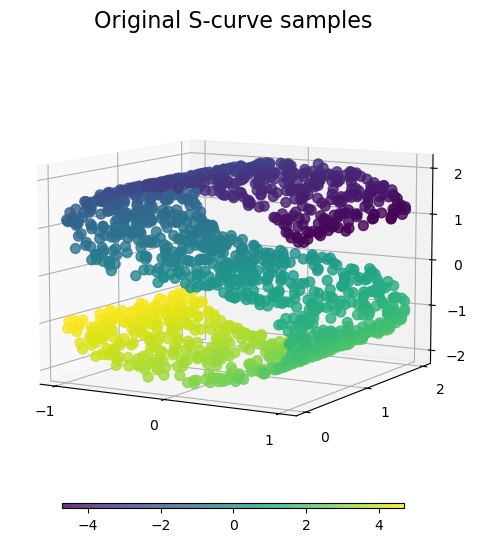

In [1]:
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker

from sklearn import datasets, manifold

n_samples = 1500
S_points, S_color = datasets.make_s_curve(n_samples, random_state=0)

def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

plot_3d(S_points, S_color, "Original S-curve samples")

[   0    0    0 ... 1499 1499 1499] 150128
[1385 1251 1129 ... 1055  701  108] 150128
[0.67926394 0.6469948  0.65408858 ... 0.25705153 0.25526588 0.20564058] 150128
float64
1500
90
150128
Spectral_fit
90
new
new1
new2
data size: 150128
col size: 150128
row size: 150128
n: 1500
k_graph.n_neighbors: 90
[[ 0.5870496  -0.5138651 ]
 [-0.7451052   0.46306822]
 [ 0.66037     1.0736375 ]
 ...
 [-0.6570863   1.041895  ]
 [ 0.7450246  -1.0391625 ]
 [ 0.6208518  -0.1025774 ]]


/home/coder/cuml/python/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


0.5155962922248009


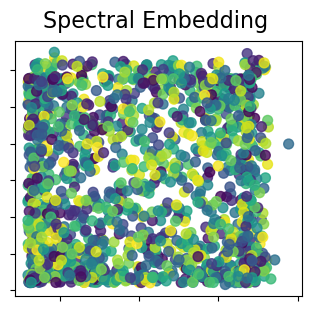

In [4]:
%reload_ext autoreload
%autoreload 2
import sklearn

from sklearn.manifold import SpectralEmbedding
from cuml.manifold import SpectralEmbedding as cuSpectralEmbedding
from sklearn.datasets import load_digits
from sklearn.manifold import trustworthiness
from cuml.manifold.umap import UMAP
from scipy.sparse import csr_matrix
import numpy as np

data_size = 1500
n_neighbors = 90

from sklearn.neighbors import kneighbors_graph
matrix1 = kneighbors_graph(
    S_points, n_neighbors, include_self=True, mode="distance",
)

matrix1 = matrix1 + matrix1.T
matrix1 = matrix1.tocoo()
print(matrix1.row, len(matrix1.row))
print(matrix1.col, len(matrix1.col))
print(matrix1.data, len(matrix1.data))
print(S_points.dtype)

s = cuSpectralEmbedding(n_components=2, n_neighbors=n_neighbors, random_state=1234, rows=matrix1.row, cols=matrix1.col, vals=matrix1.data, nnz=len(matrix1.row))
Y = s.fit_transform(S_points)
print(Y)

csr_sym = csr_matrix((s.knn_dists, (s.knn_rows, s.knn_indices)), shape=(data_size, data_size))
csr_knn = csr_matrix((s.a_knn_dists, (s.a_knn_rows, s.a_knn_indices)), shape=(data_size, data_size))

trust = trustworthiness(S_points, Y, n_neighbors=n_neighbors)
print(trust)

plot_2d(Y, S_color, "Spectral Embedding")

In [11]:
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
matrix1 = kneighbors_graph(
    S_points, n_neighbors, include_self=True, mode="distance",
)
matrix1 = matrix1 + matrix1.T
matrix2 = csr_sym

np.set_printoptions(precision=4, suppress=True)

def printlen(matrix):
    print(matrix.row, len(matrix.row))
    print(matrix.col, len(matrix.col))
    print(matrix.data, len(matrix.data))
matrix2.eliminate_zeros()
printlen(matrix2.tocoo())
matrix1.sort_indices()
# matrix1 = matrix1.astype(np.float32)
printlen(matrix1.tocoo())
print(matrix1.toarray().shape)
print(matrix1.toarray().shape)

def printNorm(matrix1, matrix2):
    norm_diff = np.linalg.norm((matrix1 - matrix2).toarray())
    
    print("Frobenius norm difference:", norm_diff)
    
    # Compute element-wise difference
    diff_matrix = matrix1.toarray() - matrix2.toarray()
    print("max diff", np.max(diff_matrix), "min diff", np.min(diff_matrix))
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(diff_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.title('Element-wise Difference between Matrices')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

# printNorm(matrix1, matrix2)

[   0    0    0 ... 1499 1499 1499] 150128
[   3   11   12 ... 1444 1467 1496] 150128
[0.2026 1.0635 0.3991 ... 1.1478 1.0173 0.881 ] 150128
[   0    0    0 ... 1499 1499 1499] 150128
[   3   11   12 ... 1444 1467 1496] 150128
[0.2026 1.0635 0.3991 ... 1.1478 1.0173 0.881 ] 150128
(1500, 1500)
(1500, 1500)


[-2.1942 -0.5436  0.    ]
[[-0.035  -0.0056  0.0258]
 [-0.0091 -0.0224  0.0258]
 [-0.0294 -0.0118  0.0258]
 ...
 [ 0.0283  0.0339  0.0258]
 [ 0.0347  0.0355  0.0258]
 [ 0.0029  0.0266  0.0258]]
[[-0.035  -0.0091 -0.0294 ...  0.0283  0.0347  0.0029]
 [-0.0056 -0.0224 -0.0118 ...  0.0339  0.0355  0.0266]
 [ 0.0258  0.0258  0.0258 ...  0.0258  0.0258  0.0258]]
(3, 1500)
[[ 0.0258  0.0258  0.0258 ...  0.0258  0.0258  0.0258]
 [-0.0056 -0.0224 -0.0118 ...  0.0339  0.0355  0.0266]
 [-0.035  -0.0091 -0.0294 ...  0.0283  0.0347  0.0029]]
(3, 1500)
[[-0.0056 -0.035 ]
 [-0.0224 -0.0091]
 [-0.0118 -0.0294]
 ...
 [ 0.0339  0.0283]
 [ 0.0355  0.0347]
 [ 0.0266  0.0029]]
[[ 0.0056  0.035 ]
 [ 0.0224  0.0091]
 [ 0.0118  0.0294]
 ...
 [-0.0339 -0.0283]
 [-0.0355 -0.0347]
 [-0.0266 -0.0029]]
0.953884608389995


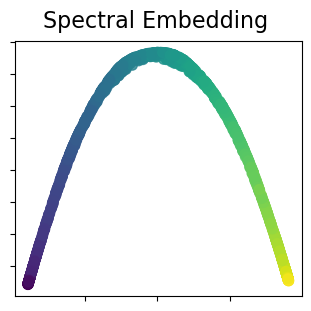

In [19]:
spectral = SpectralEmbedding(
    n_components=2, n_neighbors=n_neighbors, random_state=1234, eigen_solver='arpack'
)
# print(np.array_equal(matrix1.tocoo().row, matrix2.tocoo().row))
# print(np.array_equal(matrix1.tocoo().col, matrix2.tocoo().col))
# print(np.array_equal(matrix1.tocoo().data, matrix2.tocoo().data))

# printNorm(matrix1, matrix1.astype(np.float32))
# spectral.affinity_matrix_ = matrix1.astype(np.float32)
S_spectral = spectral.fit_transform(S_points)
print(S_spectral)

trust = trustworthiness(S_points, S_spectral, n_neighbors=n_neighbors)
print(trust)

plot_2d(S_spectral, S_color, "Spectral Embedding")

In [ ]:
# Eigenvalue comparisions

# Matrix1 with float64
[-6.80508804e-18  7.64327840e-03  3.09254206e-02  6.73858672e-02]
[[ 0.02653305 -0.00671369  0.03595412  0.01966787]
 [ 0.02561757 -0.02250575  0.0073299   0.03013086]
 [ 0.02599613 -0.01257166  0.02884746  0.03328078]
 ...
 [ 0.0279564   0.03727907 -0.02936894  0.01844672]
 [ 0.02499741  0.03480056 -0.0317993   0.02729772]
 [ 0.02539695  0.02613997 -0.00136831 -0.02095759]]

# Matrix1 with float32
[-5.1775723e-11  9.8965877e-01  1.0007300e+00  1.0062201e+00]
[[ 0.02653305 -0.02452699  0.04342616  0.00372159]
 [ 0.02561757  0.02318516  0.02157941 -0.01807453]
 [ 0.02599613 -0.04696787  0.03406713  0.04082575]
 ...
 [ 0.02795639 -0.04275984 -0.02113741  0.00657209]
 [ 0.02499741  0.00984805 -0.00410398 -0.04002177]
 [ 0.02539695  0.01094472  0.00617625 -0.01725373]]

# Matrix1 with float64 arpack

[-3.09254205e-02 -7.64327793e-03  1.99840144e-15]
[[ 0.03595485 -0.00671197  0.02653305]
 [ 0.00732909 -0.02250801  0.02561757]
 [ 0.02884834 -0.01256859  0.02599613]
 ...
 [-0.02936891  0.03727913  0.0279564 ]
 [-0.03179918  0.03480124  0.02499741]
 [-0.00136827  0.02613956  0.02539695]]
0.952800928300965

# Matrix1 with float32 arpack

[-3.0925751e-02 -7.6429844e-03 -2.3841858e-07]
[[ 0.03595522 -0.00671182  0.02653276]
 [ 0.00732942 -0.02250788  0.02561765]
 [ 0.02884873 -0.01256845  0.0259959 ]
 ...
 [-0.02936848  0.03727938  0.0279564 ]
 [-0.03179872  0.03480148  0.02499749]
 [-0.00136803  0.02613986  0.02539671]]
0.952800928300965